In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bambi as bmb
import pymc.sampling_jax
import xarray as xr
import pingouin as pg
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
data = bmb.load_data("sleepstudy")
data.head()

Reaction  Days  Subject
0  249.5600     0      308
1  258.7047     1      308
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308

In [4]:
data = data[data['Days'].isin([0, 1]) == False]
data.head()

Reaction  Days  Subject
2  250.8006     2      308
3  321.4398     3      308
4  356.8519     4      308
5  414.6901     5      308
6  382.2038     6      308

In [5]:
def plot_data(data):
    fig, axes = plt.subplots(3, 6, figsize=(16, 8), sharey=True, sharex=True, dpi=300, constrained_layout=True)
    fig.subplots_adjust(left=0.075, right=0.975, bottom=0.075, top=0.925, wspace=0.03)

    axes_flat = axes.ravel()

    for i, subject in enumerate(data["Subject"].unique()):
        ax = axes_flat[i]
        idx = data.index[data["Subject"] == subject].tolist()
        days = data.loc[idx, "Days"].values
        reaction = data.loc[idx, "Reaction"].values

        # Plot observed data points
        ax.scatter(days, reaction, color="C0", ec="black", alpha=0.7)

        # Add a title
        ax.set_title(f"Subject: {subject}", fontsize=14)

    # Remove axis labels for individual plots
    for ax in axes_flat:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set x-axis ticks for the last row
    for ax in axes[-1]:
        ax.xaxis.set_ticks([0, 2, 4, 6, 8])

    return axes

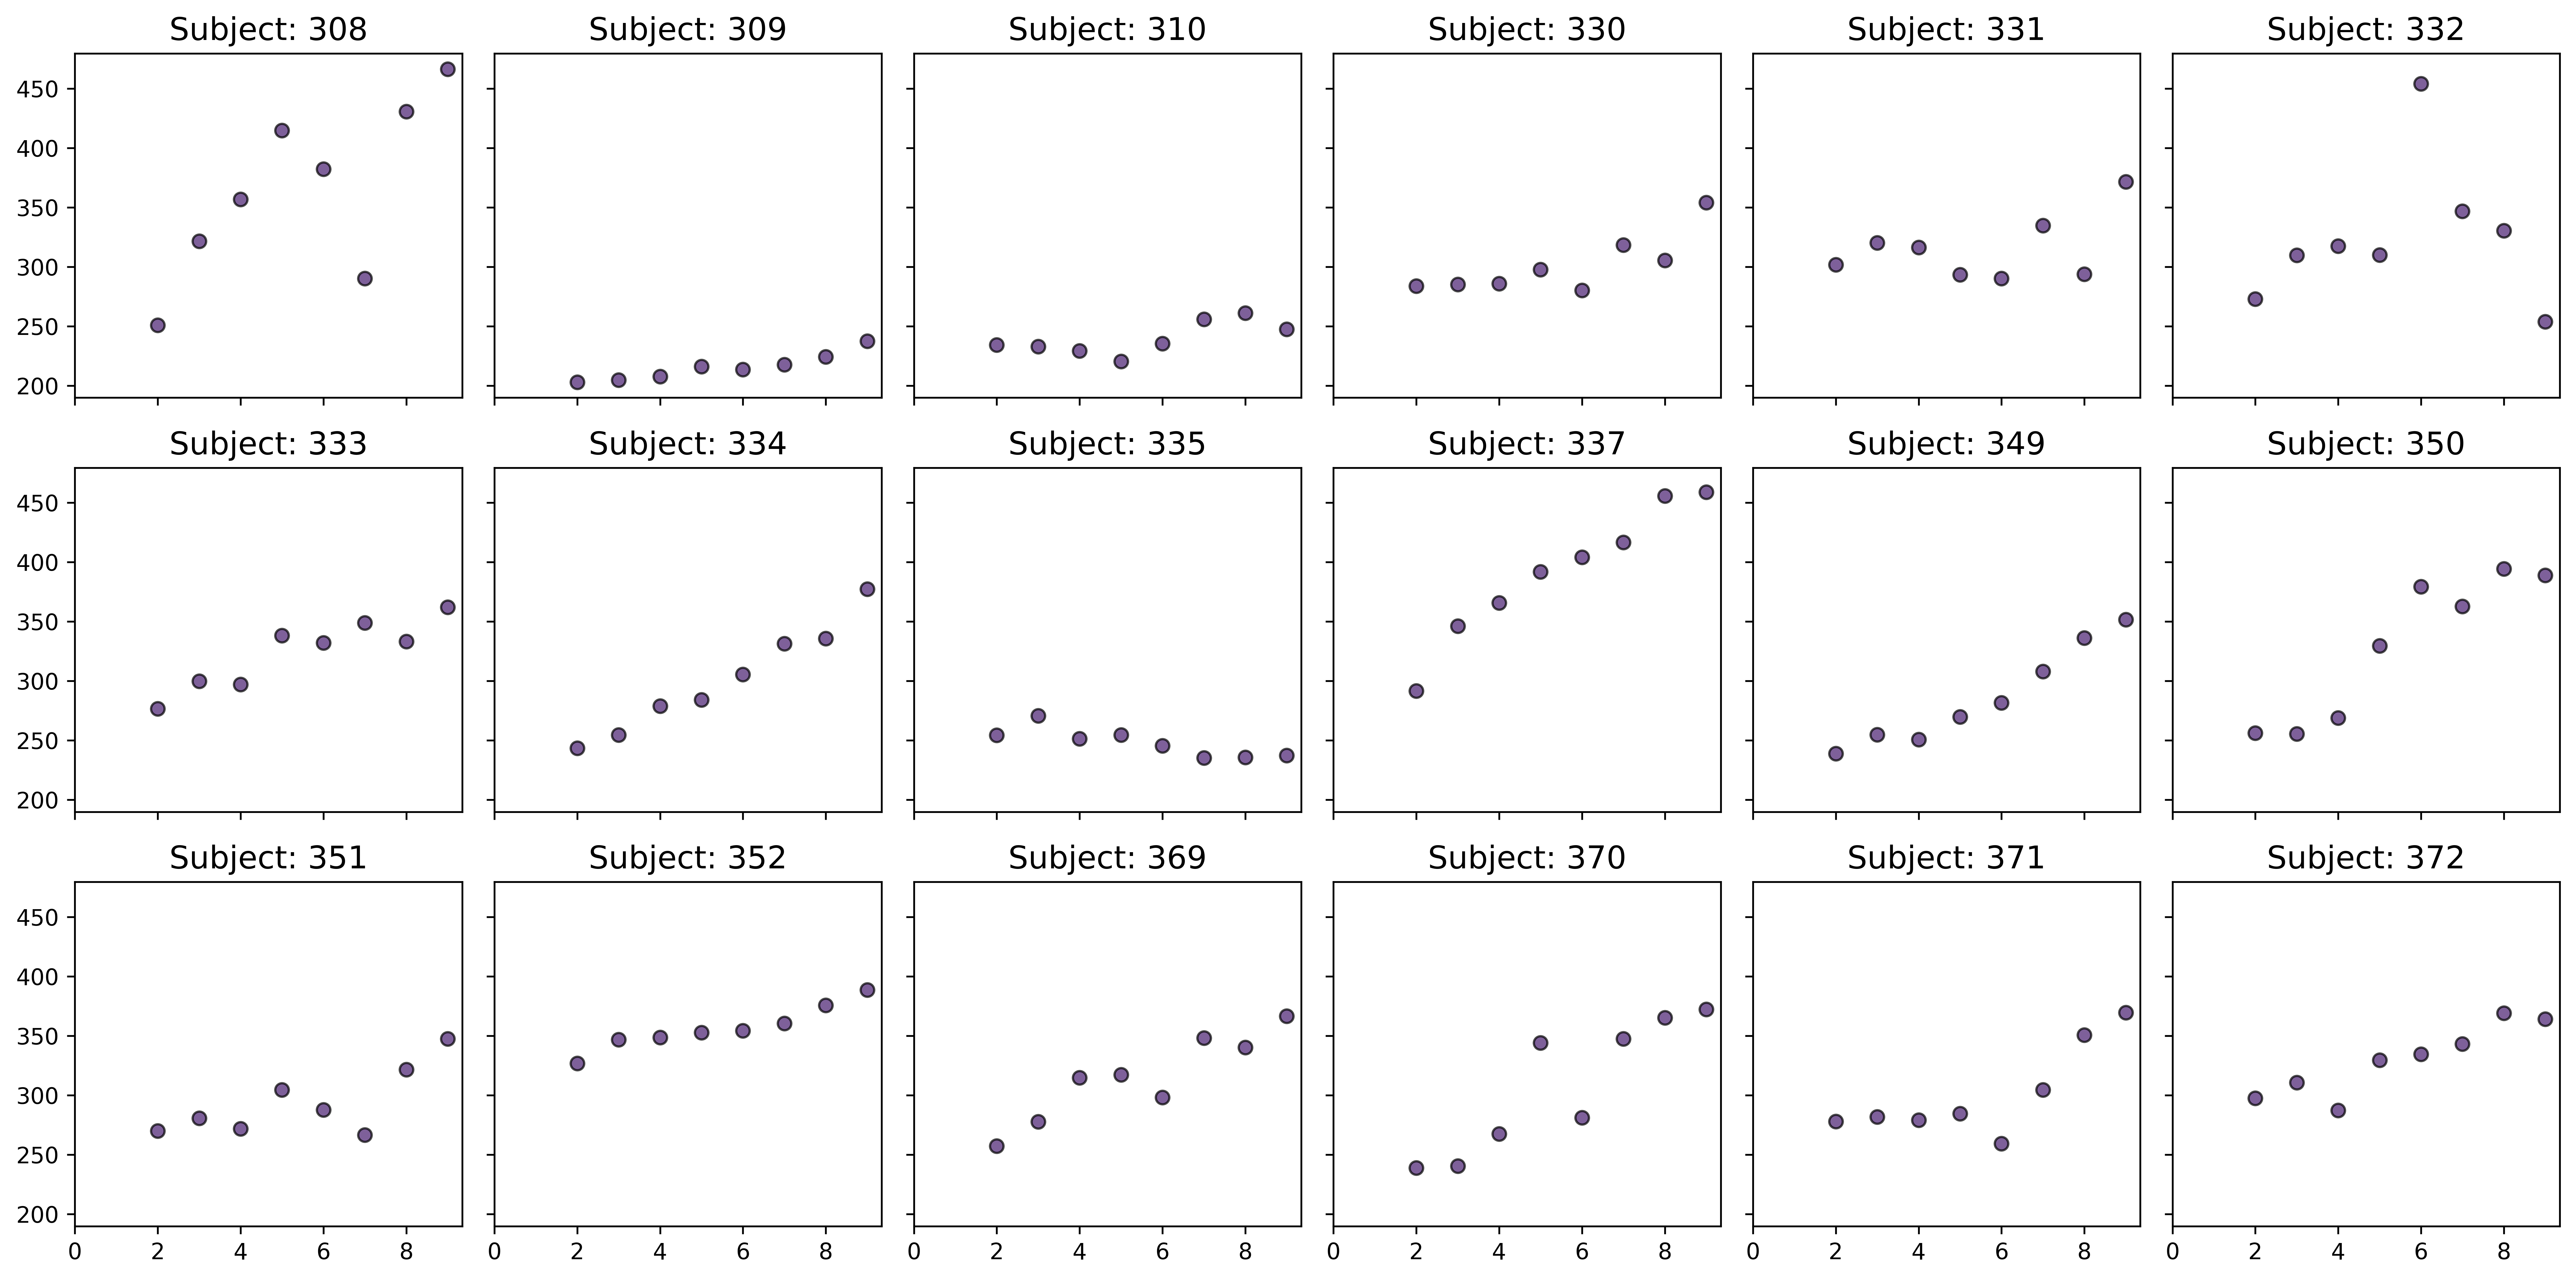

In [6]:
plot_data(data)
plt.tight_layout();

In [7]:
model_pooling = bmb.Model("Reaction ~ 1 + Days", data)

In [8]:
results_pooling = model_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Compiling...


Compilation time =  0:00:01.245298
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.760287
Transforming variables...
Transformation time =  0:00:00.016090
Computing Log Likelihood...


Log Likelihood time =  0:00:00.220740


In [9]:
az.summary(results_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       245.02  11.10  224.71   266.21       0.17     0.12   4127.01   
Days             11.44   1.84    8.02    14.88       0.03     0.02   4093.49   
Reaction_sigma   51.13   3.00   45.30    56.45       0.05     0.04   3437.83   

                ess_tail  r_hat  
Intercept        3404.42    1.0  
Days             3057.80    1.0  
Reaction_sigma   3172.79    1.0

In [10]:
model_no_pooling = bmb.Model("Reaction ~ Days * C(Subject)", data=data)
results_no_pooling = model_no_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Compiling...


Compilation time =  0:00:03.094633
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.330508
Transforming variables...
Transformation time =  0:00:00.004941
Computing Log Likelihood...
Log Likelihood time =  0:00:00.101965


In [11]:
az.summary(results_no_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept             246.20  23.49  204.42   290.66       1.30     0.92   
Days                   21.48   3.91   13.91    28.41       0.22     0.15   
C(Subject)[309]       -54.75  33.07 -117.13     6.29       1.36     0.96   
C(Subject)[310]       -28.53  32.96  -90.04    35.26       1.33     0.94   
C(Subject)[330]        11.13  33.26  -50.46    71.99       1.38     0.98   
C(Subject)[331]        41.98  33.67  -24.17   101.11       1.39     0.98   
C(Subject)[332]        64.55  33.23    3.52   127.55       1.41     1.00   
C(Subject)[333]        17.27  33.21  -46.11    79.51       1.37     0.97   
C(Subject)[334]       -44.50  32.94 -107.32    16.36       1.37     0.97   
C(Subject)[335]        25.06  33.17  -34.76    89.55       1.39     0.99   
C(Subject)[337]        22.27  33.46  -44.92    80.69       1.38     0.98   
C(Subject)[349]       -50.15  33.12 -109.72    13.38       1.39     0.98   
C(Subject)[350]       -44.04  32.93 -107.59    15.99       1.38     0.98   
C(Subject)[351]         0.75  33.32  -60.20    63.55       1.41     1.00   
C(Subject)[352]        70.66  33.40    5.40   130.57       1.41     1.00   
C(Subject)[369]        -6.87  33.15  -67.15    54.41       1.37     0.97   
C(Subject)[370]       -52.49  32.95 -116.70     5.76       1.38     0.98   
C(Subject)[371]       -12.60  32.94  -72.48    51.56       1.37     0.97   
C(Subject)[372]        22.23  32.71  -40.37    82.06       1.41     1.00   
Days:C(Subject)[309]  -17.12   5.50  -27.17    -6.73       0.23     0.16   
Days:C(Subject)[310]  -17.49   5.54  -28.69    -7.71       0.22     0.16   
Days:C(Subject)[330]  -13.50   5.53  -23.26    -2.90       0.23     0.16   
Days:C(Subject)[331]  -16.58   5.66  -26.90    -5.84       0.23     0.16   
Days:C(Subject)[332]  -19.01   5.55  -29.40    -8.65       0.23     0.16   
Days:C(Subject)[333]  -10.57   5.58  -21.02    -0.09       0.23     0.16   
Days:C(Subject)[334]   -3.38   5.54  -13.77     7.17       0.23     0.16   
Days:C(Subject)[335]  -25.66   5.55  -35.58   -14.71       0.23     0.17   
Days:C(Subject)[337]    0.91   5.63   -9.11    11.97       0.23     0.16   
Days:C(Subject)[349]   -5.05   5.52  -15.26     5.06       0.23     0.16   
Days:C(Subject)[350]    1.76   5.52   -7.94    12.54       0.23     0.16   
Days:C(Subject)[351]  -12.93   5.54  -23.30    -2.42       0.23     0.16   
Days:C(Subject)[352]  -14.20   5.52  -24.27    -3.66       0.23     0.16   
Days:C(Subject)[369]   -7.72   5.48  -18.60     1.72       0.23     0.16   
Days:C(Subject)[370]   -0.87   5.55  -10.86     9.63       0.23     0.17   
Days:C(Subject)[371]   -9.21   5.55  -19.54     1.35       0.23     0.16   
Days:C(Subject)[372]  -10.36   5.50  -20.61    -0.11       0.24     0.17   
Reaction_sigma         25.74   1.72   22.69    29.02       0.03     0.02   

                      ess_bulk  ess_tail  r_hat  
Intercept               328.73    721.08   1.02  
Days                    331.24    836.40   1.02  
C(Subject)[309]         588.68   1556.12   1.01  
C(Subject)[310]         614.53   1228.25   1.01  
C(Subject)[330]         581.41   1441.04   1.01  
C(Subject)[331]         588.83   1581.38   1.01  
C(Subject)[332]         556.29   1358.34   1.01  
C(Subject)[333]         584.69   1445.37   1.01  
C(Subject)[334]         576.19   1307.41   1.01  
C(Subject)[335]         566.80   1408.16   1.01  
C(Subject)[337]         588.77   1336.03   1.01  
C(Subject)[349]         567.45   1543.26   1.01  
C(Subject)[350]         567.35   1430.26   1.01  
C(Subject)[351]         559.61   1534.58   1.01  
C(Subject)[352]         561.43   1077.15   1.01  
C(Subject)[369]         582.57   1539.59   1.01  
C(Subject)[370]         570.47   1276.53   1.01  
C(Subject)[371]         578.41   1521.71   1.01  
C(Subject)[372]         536.78   1325.16   1.01  
Days:C(Subject)[309]    598.06   1754.20   1.01  
Days:C(Subject)[310]    607.43   1259.96   1.01  
Days:C(Subject)[330]    585.19   15

In [12]:
246.98 + -55.29

191.69

In [13]:
21.30 + -16.97

4.330000000000002

In [14]:
data_subject_309 = data[data["Subject"] == 309]
data_subject_309.shape

(8, 3)

In [15]:
result = pg.linear_regression(data_subject_309["Days"], data_subject_309["Reaction"])
print(result)

       names        coef        se          T          pval        r2  \
0  Intercept  191.576970  3.723259  51.454104  3.615788e-09  0.890144   
1       Days    4.357144  0.624898   6.972569  4.325982e-04  0.890144   

     adj_r2    CI[2.5%]   CI[97.5%]  
0  0.871834  182.466483  200.687457  
1  0.871834    2.828074    5.886214  Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.



In [16]:
model_partial_pooling = bmb.Model(
    "Reaction ~ 1 + Days + (Days | Subject)", data, categorical="Subject"
)

In [17]:
results_partial_pooling = model_partial_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Compiling...


Compilation time =  0:00:02.675412
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.467341
Transforming variables...
Transformation time =  0:00:00.023370
Computing Log Likelihood...
Log Likelihood time =  0:00:00.175490


In [18]:
az.summary(results_partial_pooling, round_to=2)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           244.95   9.41  227.47   262.91       0.18     0.13   
Days                 11.39   1.93    7.94    15.16       0.05     0.04   
Reaction_sigma       26.10   1.84   22.75    29.51       0.03     0.02   
1|Subject_sigma      31.07   8.76   16.86    49.62       0.21     0.15   
Days|Subject_sigma    6.88   1.63    4.28    10.13       0.04     0.03   
1|Subject[308]       10.25  18.98  -26.71    46.38       0.31     0.27   
1|Subject[309]      -42.38  20.31  -80.39    -4.53       0.36     0.25   
1|Subject[310]      -25.19  18.84  -61.15     8.20       0.32     0.24   
1|Subject[330]        4.44  17.80  -31.30    36.22       0.30     0.27   
1|Subject[331]       22.61  18.69  -12.59    57.77       0.31     0.23   
1|Subject[332]       34.31  19.23   -0.74    71.62       0.33     0.24   
1|Subject[333]       12.19  18.20  -20.30    47.69       0.30     0.25   
1|Subject[334]      -21.76  18.50  -55.25    13.32       0.33     0.24   
1|Subject[335]        1.73  19.25  -33.02    39.71       0.31     0.27   
1|Subject[337]       25.96  19.46  -11.10    61.97       0.32     0.25   
1|Subject[349]      -27.28  19.52  -64.48     7.24       0.33     0.24   
1|Subject[350]      -16.42  18.64  -50.75    20.21       0.32     0.24   
1|Subject[351]       -1.70  18.32  -35.43    32.90       0.30     0.27   
1|Subject[352]       43.24  20.04    4.28    80.33       0.35     0.25   
1|Subject[369]       -1.37  17.98  -35.32    33.07       0.29     0.26   
1|Subject[370]      -24.65  19.13  -62.03     9.42       0.34     0.25   
1|Subject[371]       -6.88  18.34  -42.01    27.19       0.31     0.25   
1|Subject[372]       15.17  18.61  -18.89    50.44       0.30     0.24   
Days|Subject[308]     8.19   3.44    1.61    14.56       0.07     0.05   
Days|Subject[309]    -8.29   3.57  -15.22    -1.70       0.07     0.05   
Days|Subject[310]    -7.33   3.35  -13.52    -0.89       0.07     0.05   
Days|Subject[330]    -2.11   3.20   -8.04     3.85       0.07     0.05   
Days|Subject[331]    -3.09   3.35   -8.96     3.50       0.06     0.05   
Days|Subject[332]    -3.81   3.39  -10.21     2.57       0.07     0.05   
Days|Subject[333]     0.52   3.34   -5.95     6.60       0.07     0.05   
Days|Subject[334]     3.24   3.38   -3.95     9.07       0.07     0.05   
Days|Subject[335]   -11.15   3.52  -17.53    -4.36       0.07     0.05   
Days|Subject[337]    10.02   3.47    3.15    16.19       0.07     0.05   
Days|Subject[349]     1.63   3.52   -4.64     8.54       0.07     0.05   
Days|Subject[350]     7.33   3.45    0.62    13.70       0.07     0.05   
Days|Subject[351]    -2.15   3.27   -8.22     3.99       0.07     0.05   
Days|Subject[352]     0.23   3.49   -5.93     7.18       0.07     0.05   
Days|Subject[369]     1.65   3.32   -4.37     8.15       0.07     0.05   
Days|Subject[370]     4.85   3.41   -1.77    11.09       0.07     0.05   
Days|Subject[371]     0.16   3.33   -6.19     6.22       0.07     0.05   
Days|Subject[372]     0.97   3.29   -5.43     6.95       0.07     0.05   

                    ess_bulk  ess_tail  r_hat  
Intercept            2658.00   2898.26    1.0  
Days                 1382.03   1982.53    1.0  
Reaction_sigma       3141.82   2885.41    1.0  
1|Subject_sigma      1675.04   1988.52    1.0  
Days|Subject_sigma   1705.76   1913.41    1.0  
1|Subject[308]       3702.90   2881.39    1.0  
1|Subject[309]       3235.76   2289.11    1.0  
1|Subject[310]       3501.90   3110.37    1.0  
1|Subject[330]       3488.16   2534.59    1.0  
1|Subject[331]       3672.71   3133.27    1.0  
1|Subject[332]       3337.74   2998.59    1.0  
1|Subject[333]       3778.09   2919.75    1.0  
1|Subject[334]       3015.43   3038.12    1.0  
1|Subject[335]       3970.85   3222.35    1.0  
1|Subject[337]       3683.63   3127.15    1.0  
1|Subject[349]       3413.63   2930.47    1.0  
1|Subject[350]       3420.02   2900.50    1.0  
1|Subject[351]       3826.94   3113.07    1.0  
1

In [19]:
245.25 + -43.14

202.11

In [20]:
11.33 + -8.14

3.1899999999999995

In [21]:
az.summary(results_partial_pooling, var_names=["Intercept", "Days"], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  244.95  9.41  227.47   262.91       0.18     0.13   2658.00   
Days        11.39  1.93    7.94    15.16       0.05     0.04   1382.03   

           ess_tail  r_hat  
Intercept   2898.26    1.0  
Days        1982.53    1.0

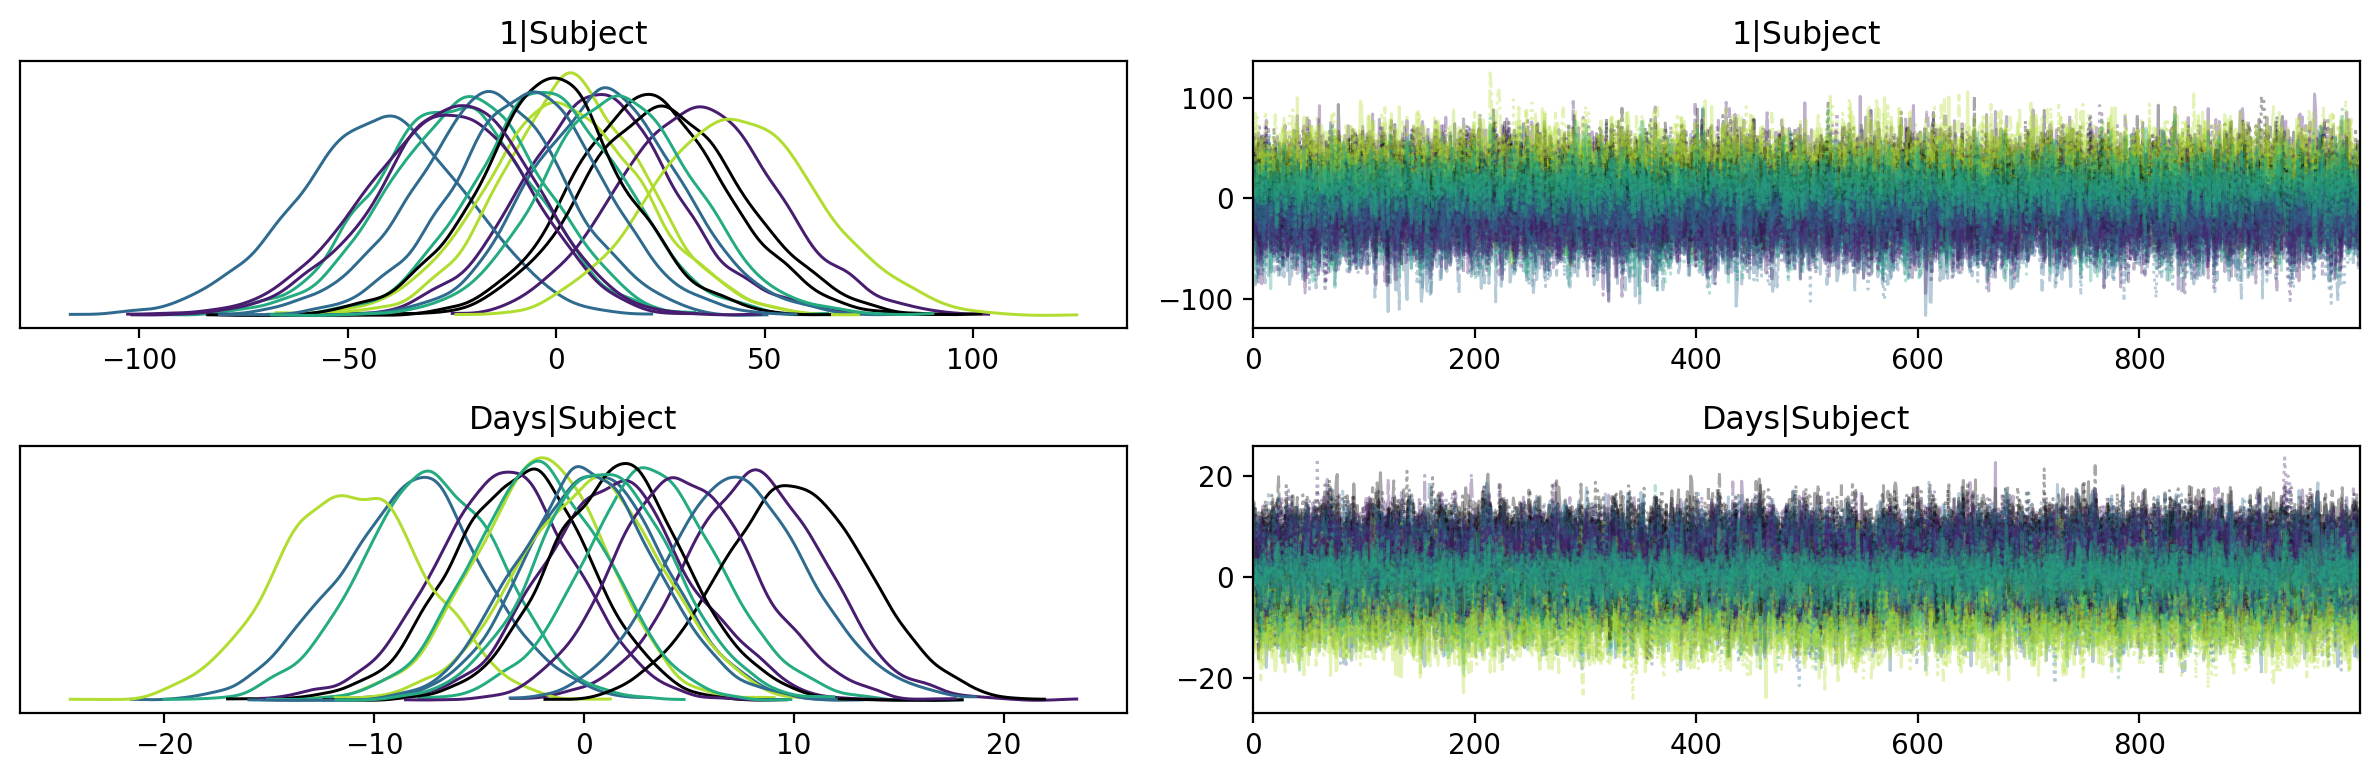

In [22]:
az.plot_trace(
    results_partial_pooling, combined=True, var_names=["1|Subject", "Days|Subject"]
)
plt.tight_layout()

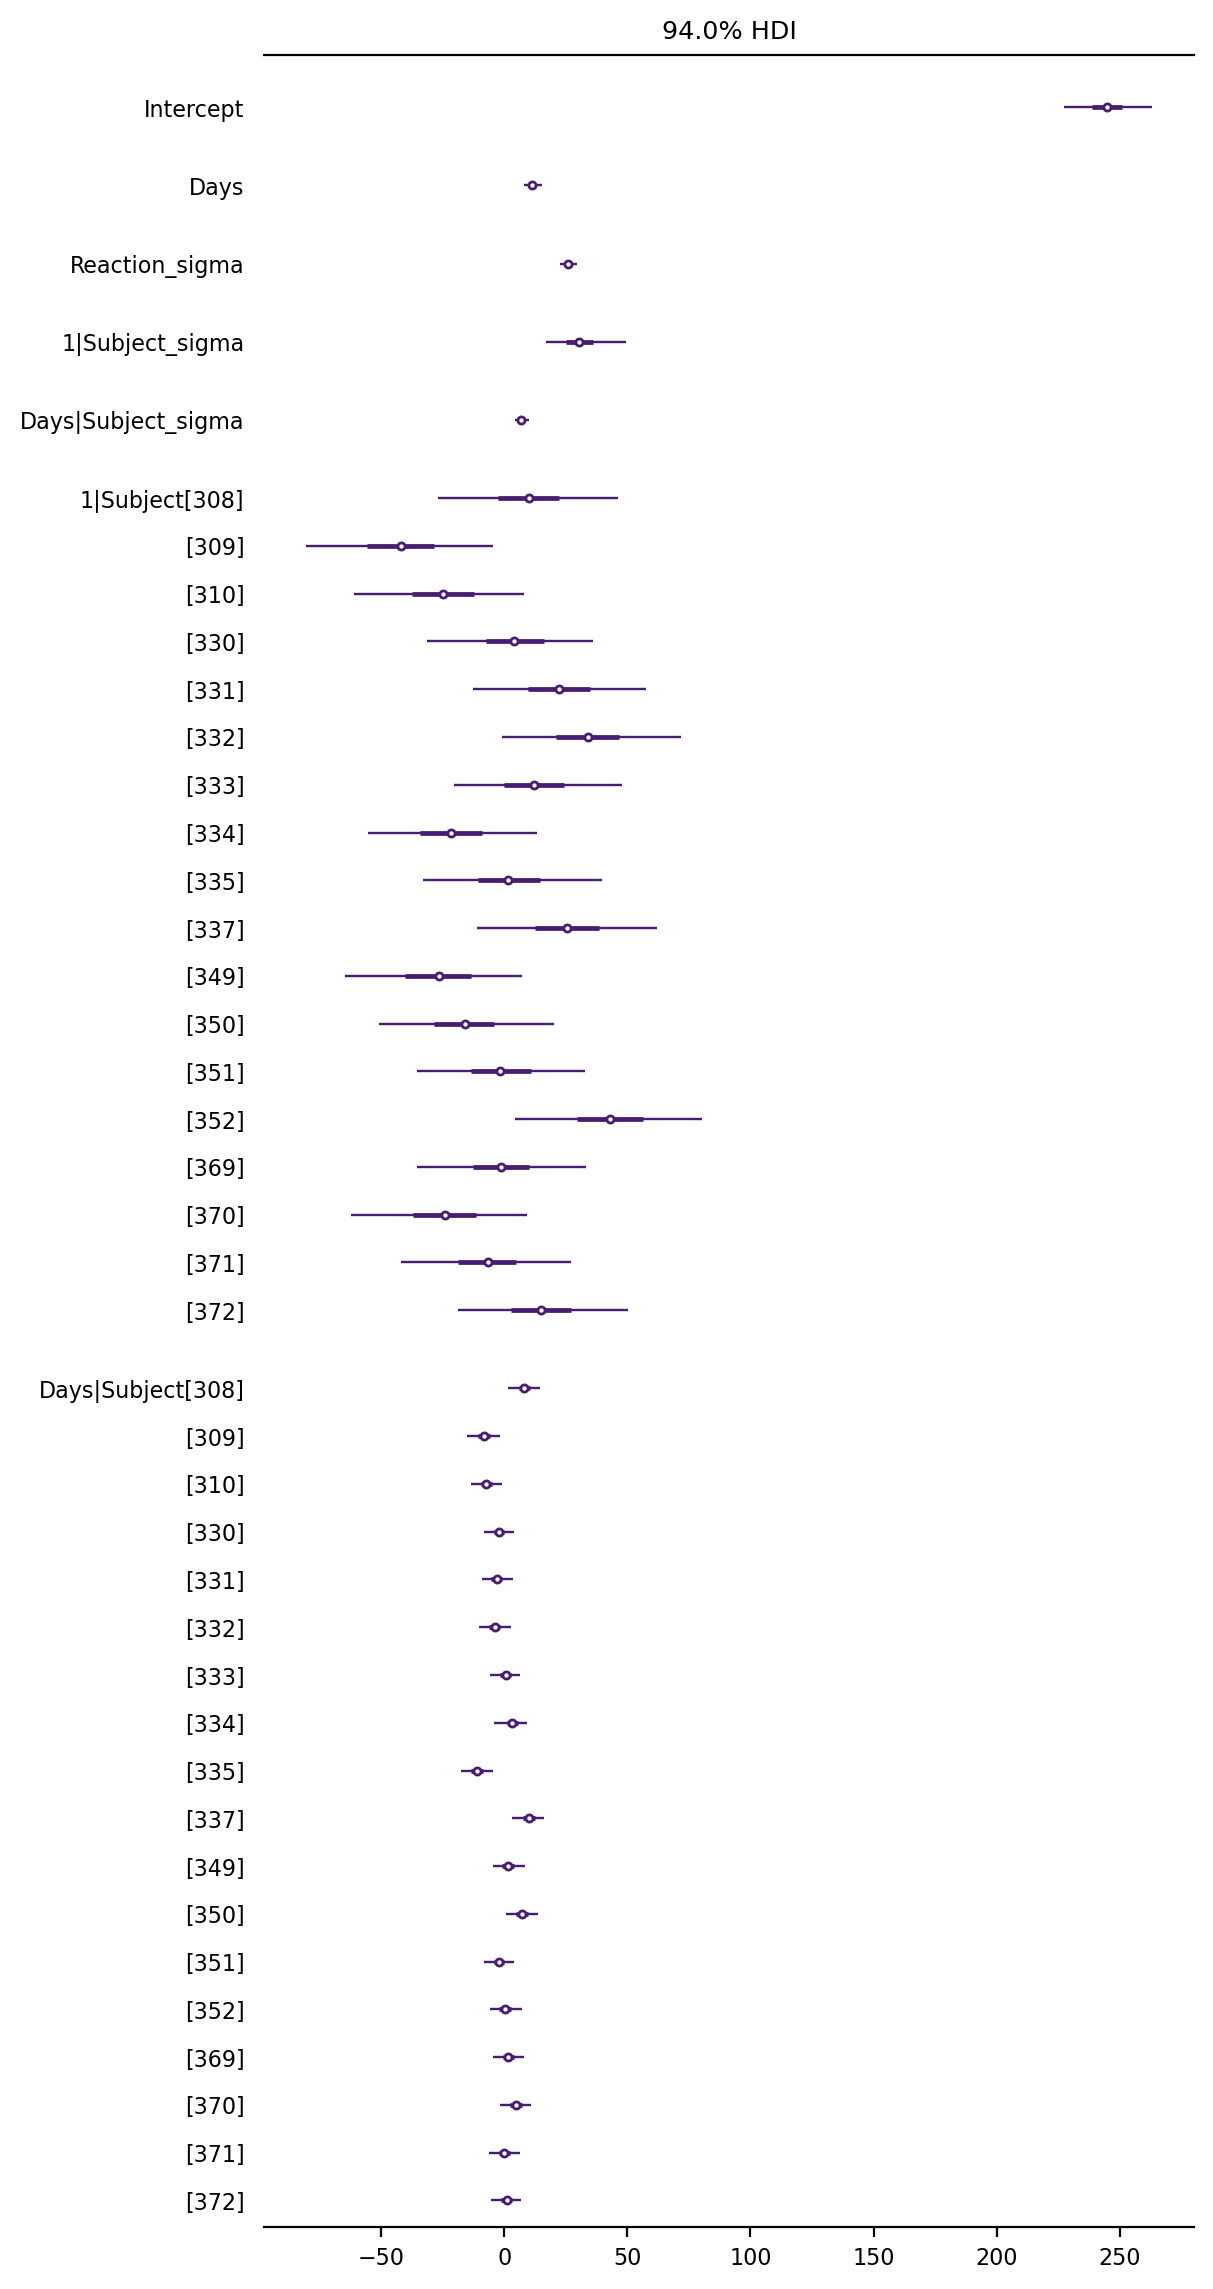

In [23]:
az.plot_forest(data=results_partial_pooling, r_hat=False, combined=True, textsize=8);

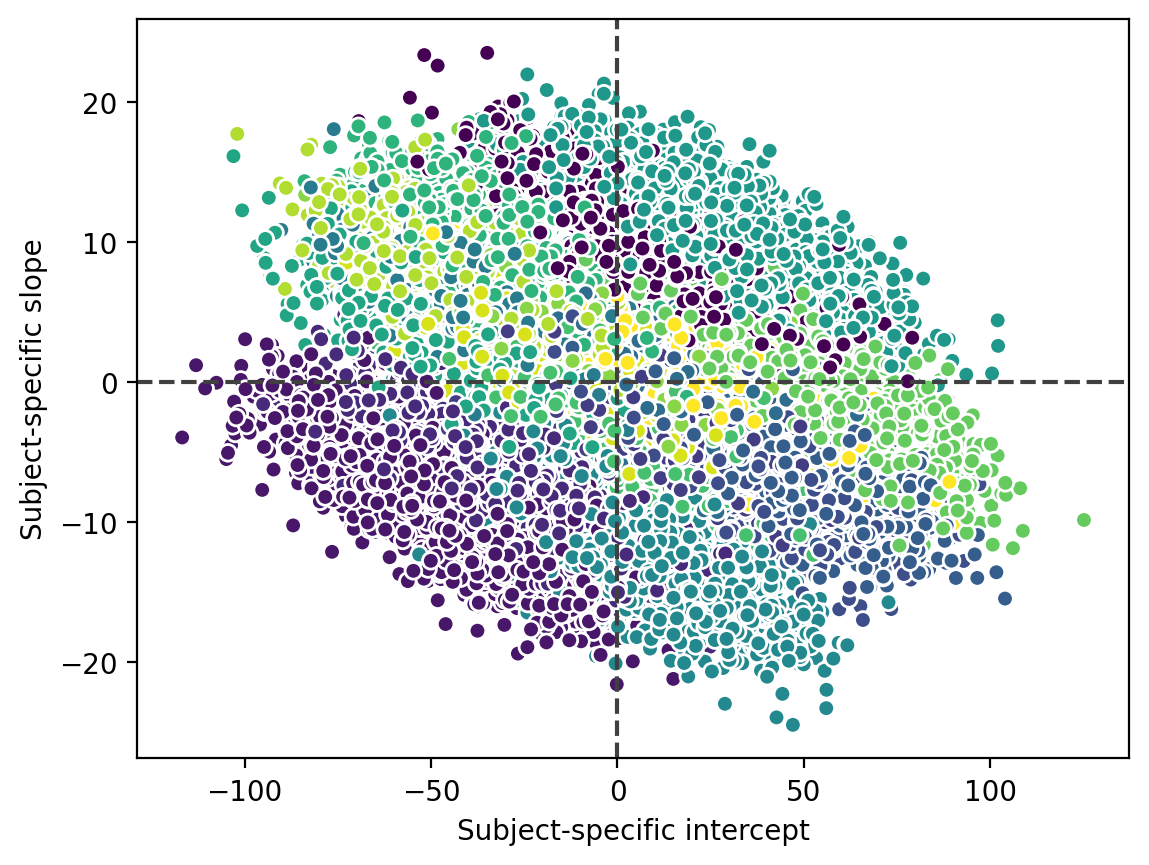

In [24]:
#  extract a subsample from the posterior and stack the chain and draw dims
posterior = az.extract(results_partial_pooling, num_samples=500)

_, ax = plt.subplots()

results_partial_pooling.posterior.plot.scatter(
    x="1|Subject", y="Days|Subject",
    hue="Subject__factor_dim",
    add_colorbar=False,
    add_legend=False,
    cmap="viridis",
    edgecolors=None,
)

ax.axhline(c="0.25", ls="--")
ax.axvline(c="0.25", ls="--")
ax.set_xlabel("Subject-specific intercept")
ax.set_ylabel("Subject-specific slope");

In [25]:
models_dict = {
    "pooling": results_pooling,
    "no_pooling": results_no_pooling,
    "partial_pooling": results_partial_pooling
}
df_compare = az.compare(models_dict)
df_compare

rank    elpd_loo      p_loo  elpd_diff    weight         se  \
partial_pooling     0 -692.743390  31.253129   0.000000  0.629932  21.795205   
no_pooling          1 -694.030464  35.711966   1.287074  0.319951  21.932340   
pooling             2 -772.174642   3.039709  79.431251  0.050117   9.022836   

                       dse  warning scale  
partial_pooling   0.000000     True   log  
no_pooling        3.106423     True   log  
pooling          20.325676    False   log

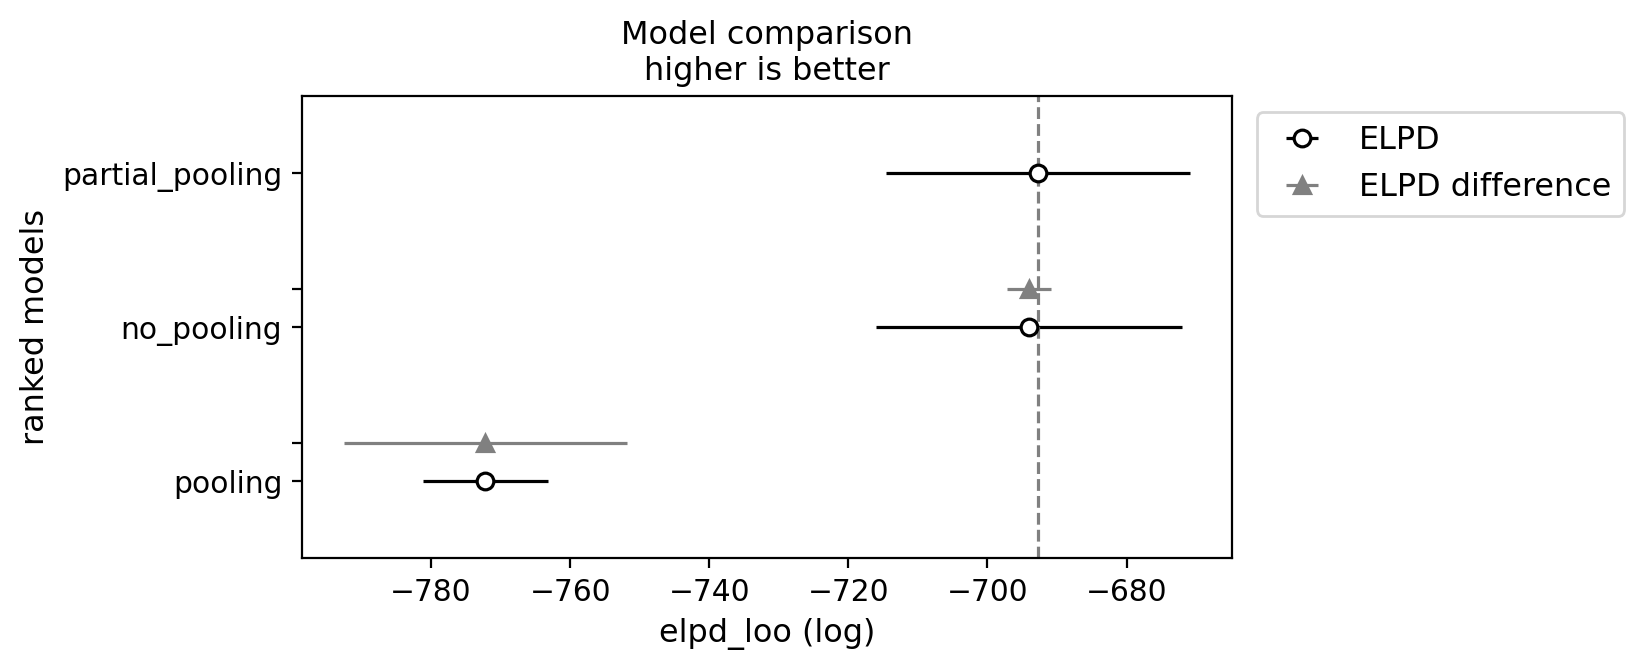

In [26]:
az.plot_compare(df_compare, insample_dev=False);

In [27]:
model_pooling_fitted = model_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)
model_pooling.predict(model_pooling_fitted, kind="pps")

Compiling...


Compilation time =  0:00:00.536888
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.619683
Transforming variables...
Transformation time =  0:00:00.005056
Computing Log Likelihood...
Log Likelihood time =  0:00:00.060696


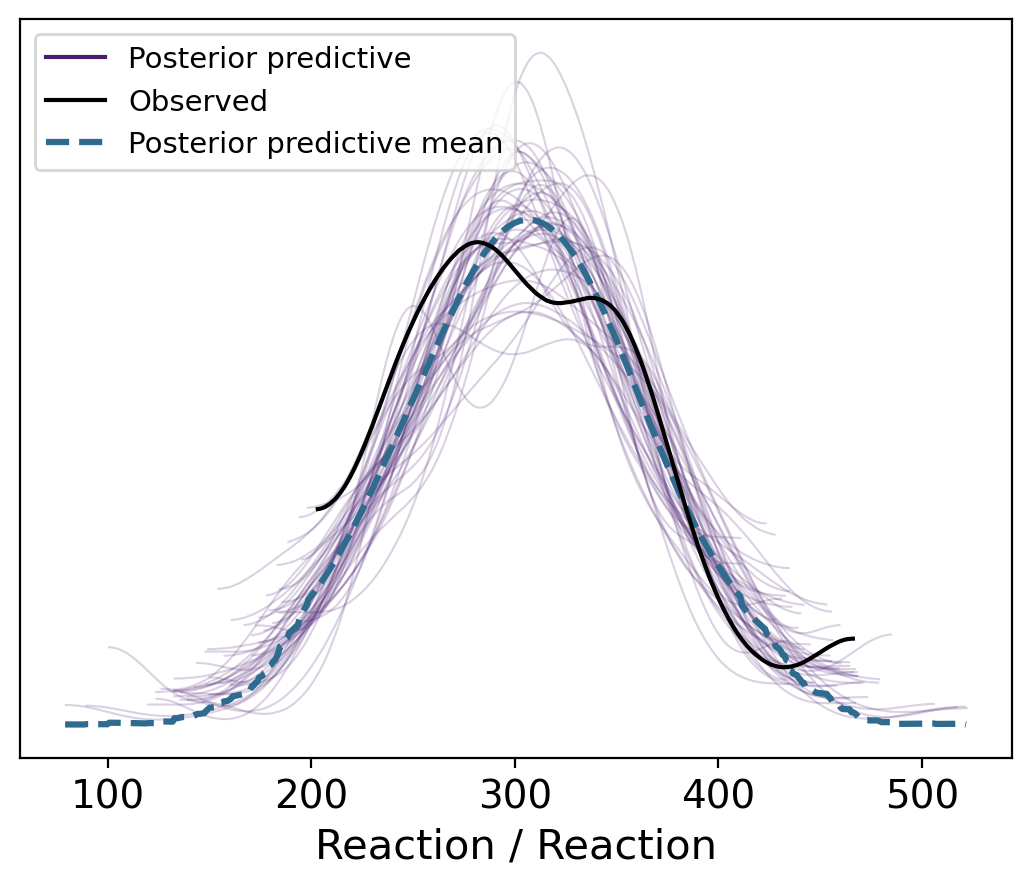

In [28]:
az.plot_ppc(model_pooling_fitted, num_pp_samples=50);

In [29]:
model_no_pooling_fitted = model_no_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)
model_no_pooling.predict(model_no_pooling_fitted, kind="pps");

Compiling...


Compilation time =  0:00:00.778679
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.390504
Transforming variables...
Transformation time =  0:00:00.004912
Computing Log Likelihood...
Log Likelihood time =  0:00:00.071102


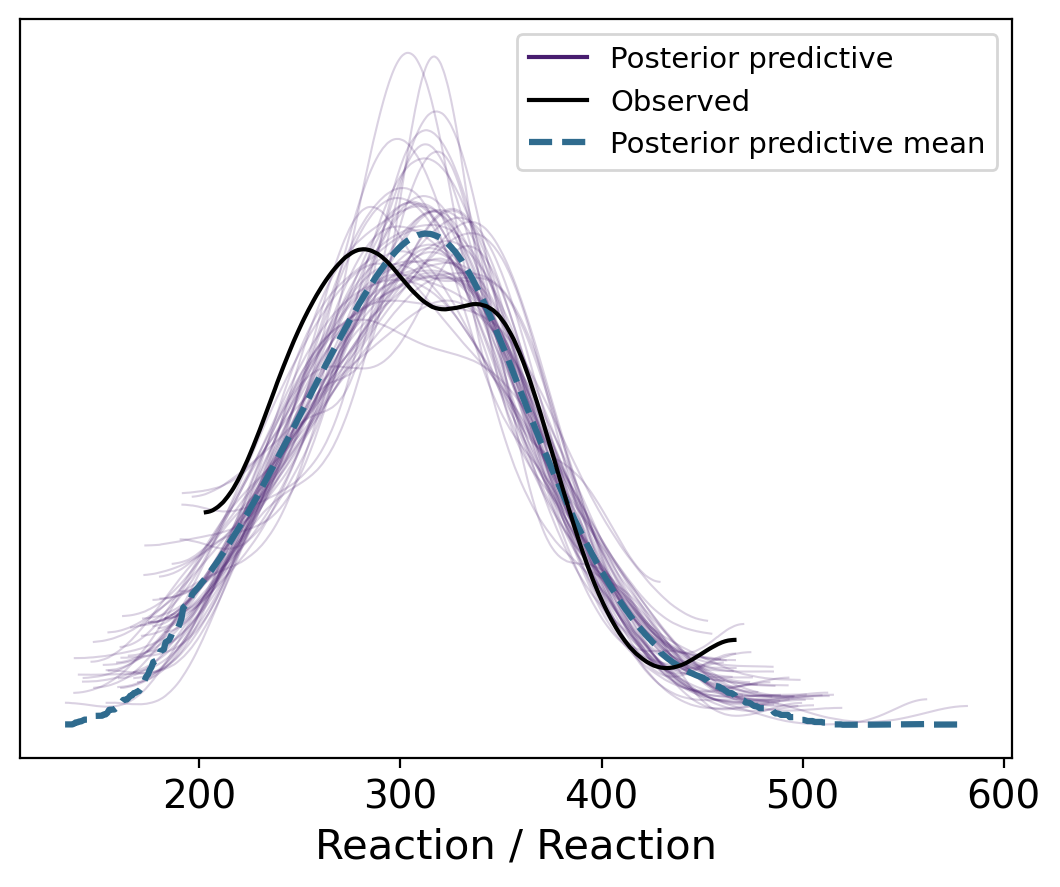

In [30]:
az.plot_ppc(model_no_pooling_fitted, num_pp_samples=50);

In [31]:
model_partial_pooling_fitted = model_partial_pooling.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)
model_partial_pooling.predict(model_partial_pooling_fitted, kind="pps");

Compiling...


Compilation time =  0:00:01.008141
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:02.514047
Transforming variables...
Transformation time =  0:00:00.011360
Computing Log Likelihood...
Log Likelihood time =  0:00:00.105746


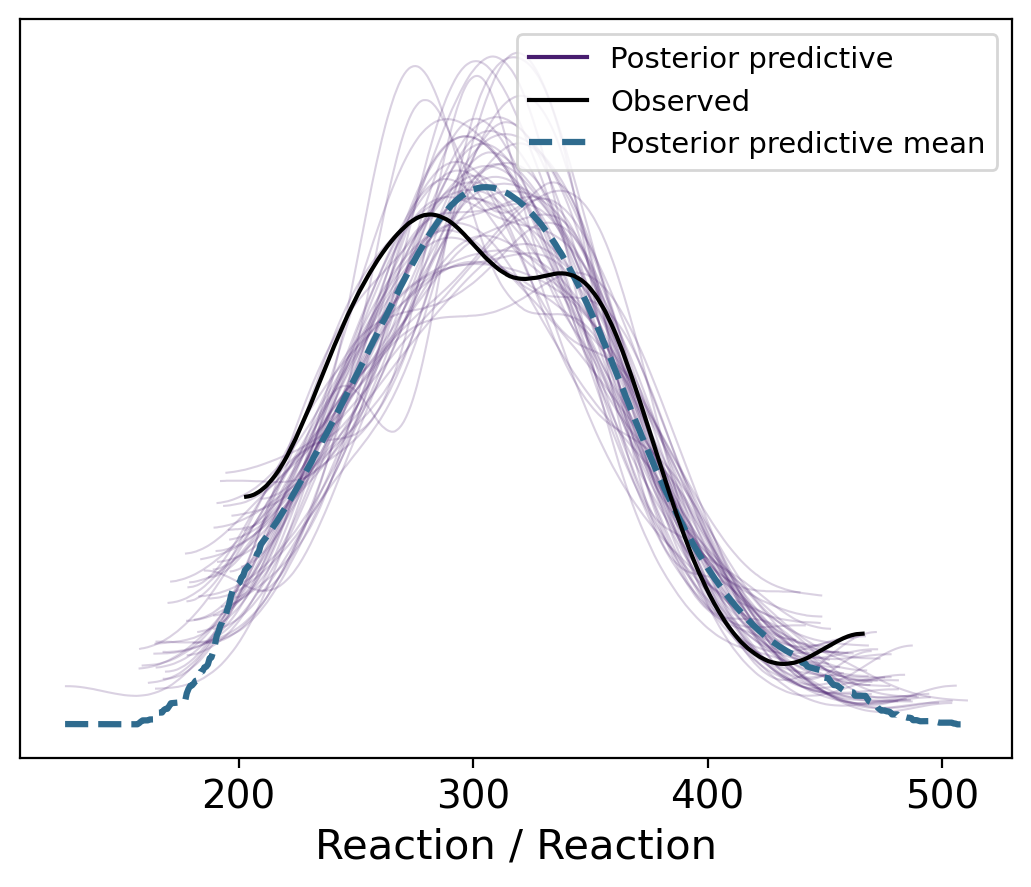

In [32]:
az.plot_ppc(model_partial_pooling_fitted, num_pp_samples=50);

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.12.3

pymc      : 5.6.1
xarray    : 2023.6.0
pingouin  : 0.5.3
bambi     : 0.12.0
matplotlib: 3.7.2
arviz     : 0.16.0
pandas    : 2.0.3
seaborn   : 0.12.2
numpy     : 1.25.2

Watermark: 2.4.3

